In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier


In [35]:
input_train = pd.read_csv('x_train.csv')
output_train = pd.read_csv('y_train.csv')

#change formulation of output_train to be like the one of input_train
output_train[['date', 'station']] = output_train['index'].str.split('_', expand=True)
output_train.drop(columns=['index'], inplace=True)#Inclusion du nom des stations

output_train = output_train[['date', 'station', 'y']]

In [51]:
##verify data

print("Duplicates check:")
if input_train[input_train.duplicated()].empty:
    print('     There are no duplicates in input_train')
else:
    input_train = input_train.drop_duplicates()
    print('     There are duplicates in input_train and they have been eliminated')
    
if output_train[output_train.duplicated()].empty:
    print('     There are no duplicates in output_train')
else:
    output_train = output_train.drop_duplicates() 
    print('     There are duplicates in output_train and they have been eliminated')
   
print("NaN check:")
if input_train.isnull().any().any():
    print('     There are NaNs in input_train')
    input_train.dropna(inplace=True)  # Drop rows with NaN values
    print('     NaN rows have been removed from input_train')
else:
    print('     There are no NaNs in input_train')

if output_train.isnull().any().any():
    print('     There are NaNs in output_train')
    output_train.dropna(inplace=True)  # Drop rows with NaN values
    print('     NaN rows have been removed from output_train')
else:
    print('     There are no NaNs in output_train')
    
#verif that rows are sorted the same way
comparison = (input_train.iloc[:, :2] == output_train.iloc[:, :2]).all(axis=1)
if comparison.all():
    print("Same values for each row.")
else:
    print("Different values for some rows.")
    

Duplicates check:
     There are no duplicates in input_train
     There are no duplicates in output_train
NaN check:
     There are no NaNs in input_train
     There are no NaNs in output_train
Same values for each row.


In [55]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

X = input_train
y = output_train['y']

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5)
}

# Initialize KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=42) # 20% of data used for testing

# Perform cross-validation for each model
mean_scores = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=k_fold)
    mean_scores[name] = np.mean(cv_scores)

# Print mean scores
for name, score in mean_scores.items():
    print(f"{name}: {score}")

Mean score for Linear Regression: 0.017864145394137453
Mean score for Ridge Regression: 0.017864145412465126
Mean score for Lasso Regression: 0.01786370248338298
Mean score for Elastic Net: 0.008535290483253211


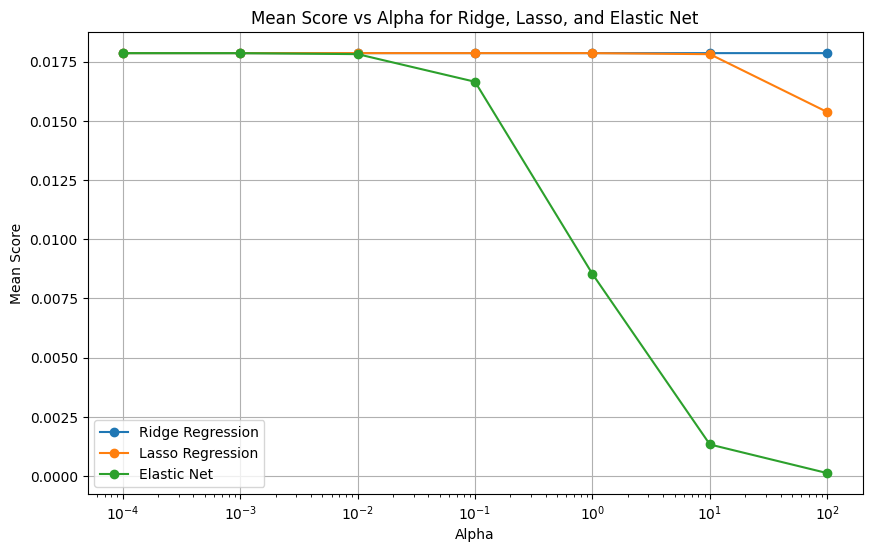

In [59]:
#Loop on hyperparameters for Ridge, Lasso, Elastic Net

# Define range of hyperparameters
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]  # Example values for alpha

# Initialize models
models_loop = {
    'Ridge Regression': Ridge,
    'Lasso Regression': Lasso,
    'Elastic Net': ElasticNet
}

# Perform cross-validation for each model and hyperparameter
results = {}
for name, model_class in models_loop.items():
    scores = []
    for alpha in alphas:
        model = model_class(alpha=alpha)
        cv_scores = cross_val_score(model, X, y, cv=k_fold)
        scores.append(np.mean(cv_scores))
    results[name] = scores

# Plotting
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(alphas, scores, marker='o', label=name)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Score')
plt.title('Mean Score vs Alpha for Ridge, Lasso, and Elastic Net')
plt.legend()
plt.grid(True)
plt.show()


Best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Best score: -92093105.55000791


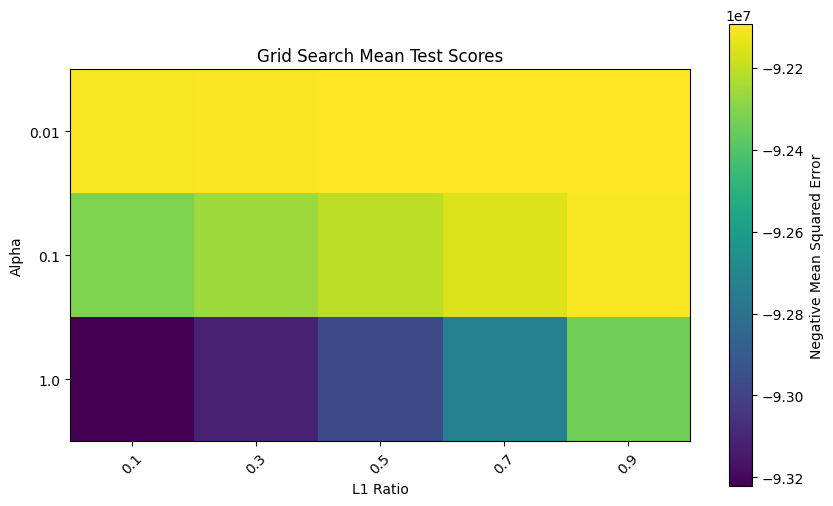

In [60]:
from sklearn.model_selection import GridSearchCV

# Define range of hyperparameters
param_grid = {
    'alpha': [0.01, 0.1, 1.0],  
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Initialize Elastic Net model
model = ElasticNet()

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=k_fold, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the results
results = grid_search.cv_results_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

# Plotting
scores = results['mean_test_score'].reshape(len(param_grid['alpha']), len(param_grid['l1_ratio']))
plt.figure(figsize=(10, 6))
plt.imshow(scores, interpolation='nearest', cmap='viridis')
plt.xlabel('L1 Ratio')
plt.ylabel('Alpha')
plt.title('Grid Search Mean Test Scores')
plt.colorbar(label='Negative Mean Squared Error')
plt.xticks(np.arange(len(param_grid['l1_ratio'])), param_grid['l1_ratio'], rotation=45)
plt.yticks(np.arange(len(param_grid['alpha'])), param_grid['alpha'])
plt.show()